In [1]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades/'
save_path=BASE+"trained_models"


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset



In [2]:
r2_m_ftr = np.load('/scratch/ab10313/pleiades/trained_models/r2_m_ftr.npy')
r2_cnn = np.load('/scratch/ab10313/pleiades/trained_models/r2_cnn.npy')
jacobian_ftr_res = np.load('/scratch/ab10313/pleiades/trained_models/jacobian_ftr_res.npy')


In [3]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


# feature importance by resolution

In [8]:
input_features_for_plot = [r'$\overline{\nabla b}^z$', '$\overline{f}$','$\overline{H_{ML}}$',r'$\overline{\tau}$', '$\overline{Q}$','$\overline{H_{BL}}$',
                 '$\overline{\delta}^z$', '$\overline{\zeta}^z$', '$\overline{\sigma}^z$' ]

ftr_ind_resort = [2, 1, 4, 7, 5, 3, 0, 6, 8 ]

res_for_plot = ['$1/12^o$','$1/8^o$','$1/4^o$','$1/2^o$','$1^o$' ]

res_strg = ['1_12','1_8','1_4','1_2','1']


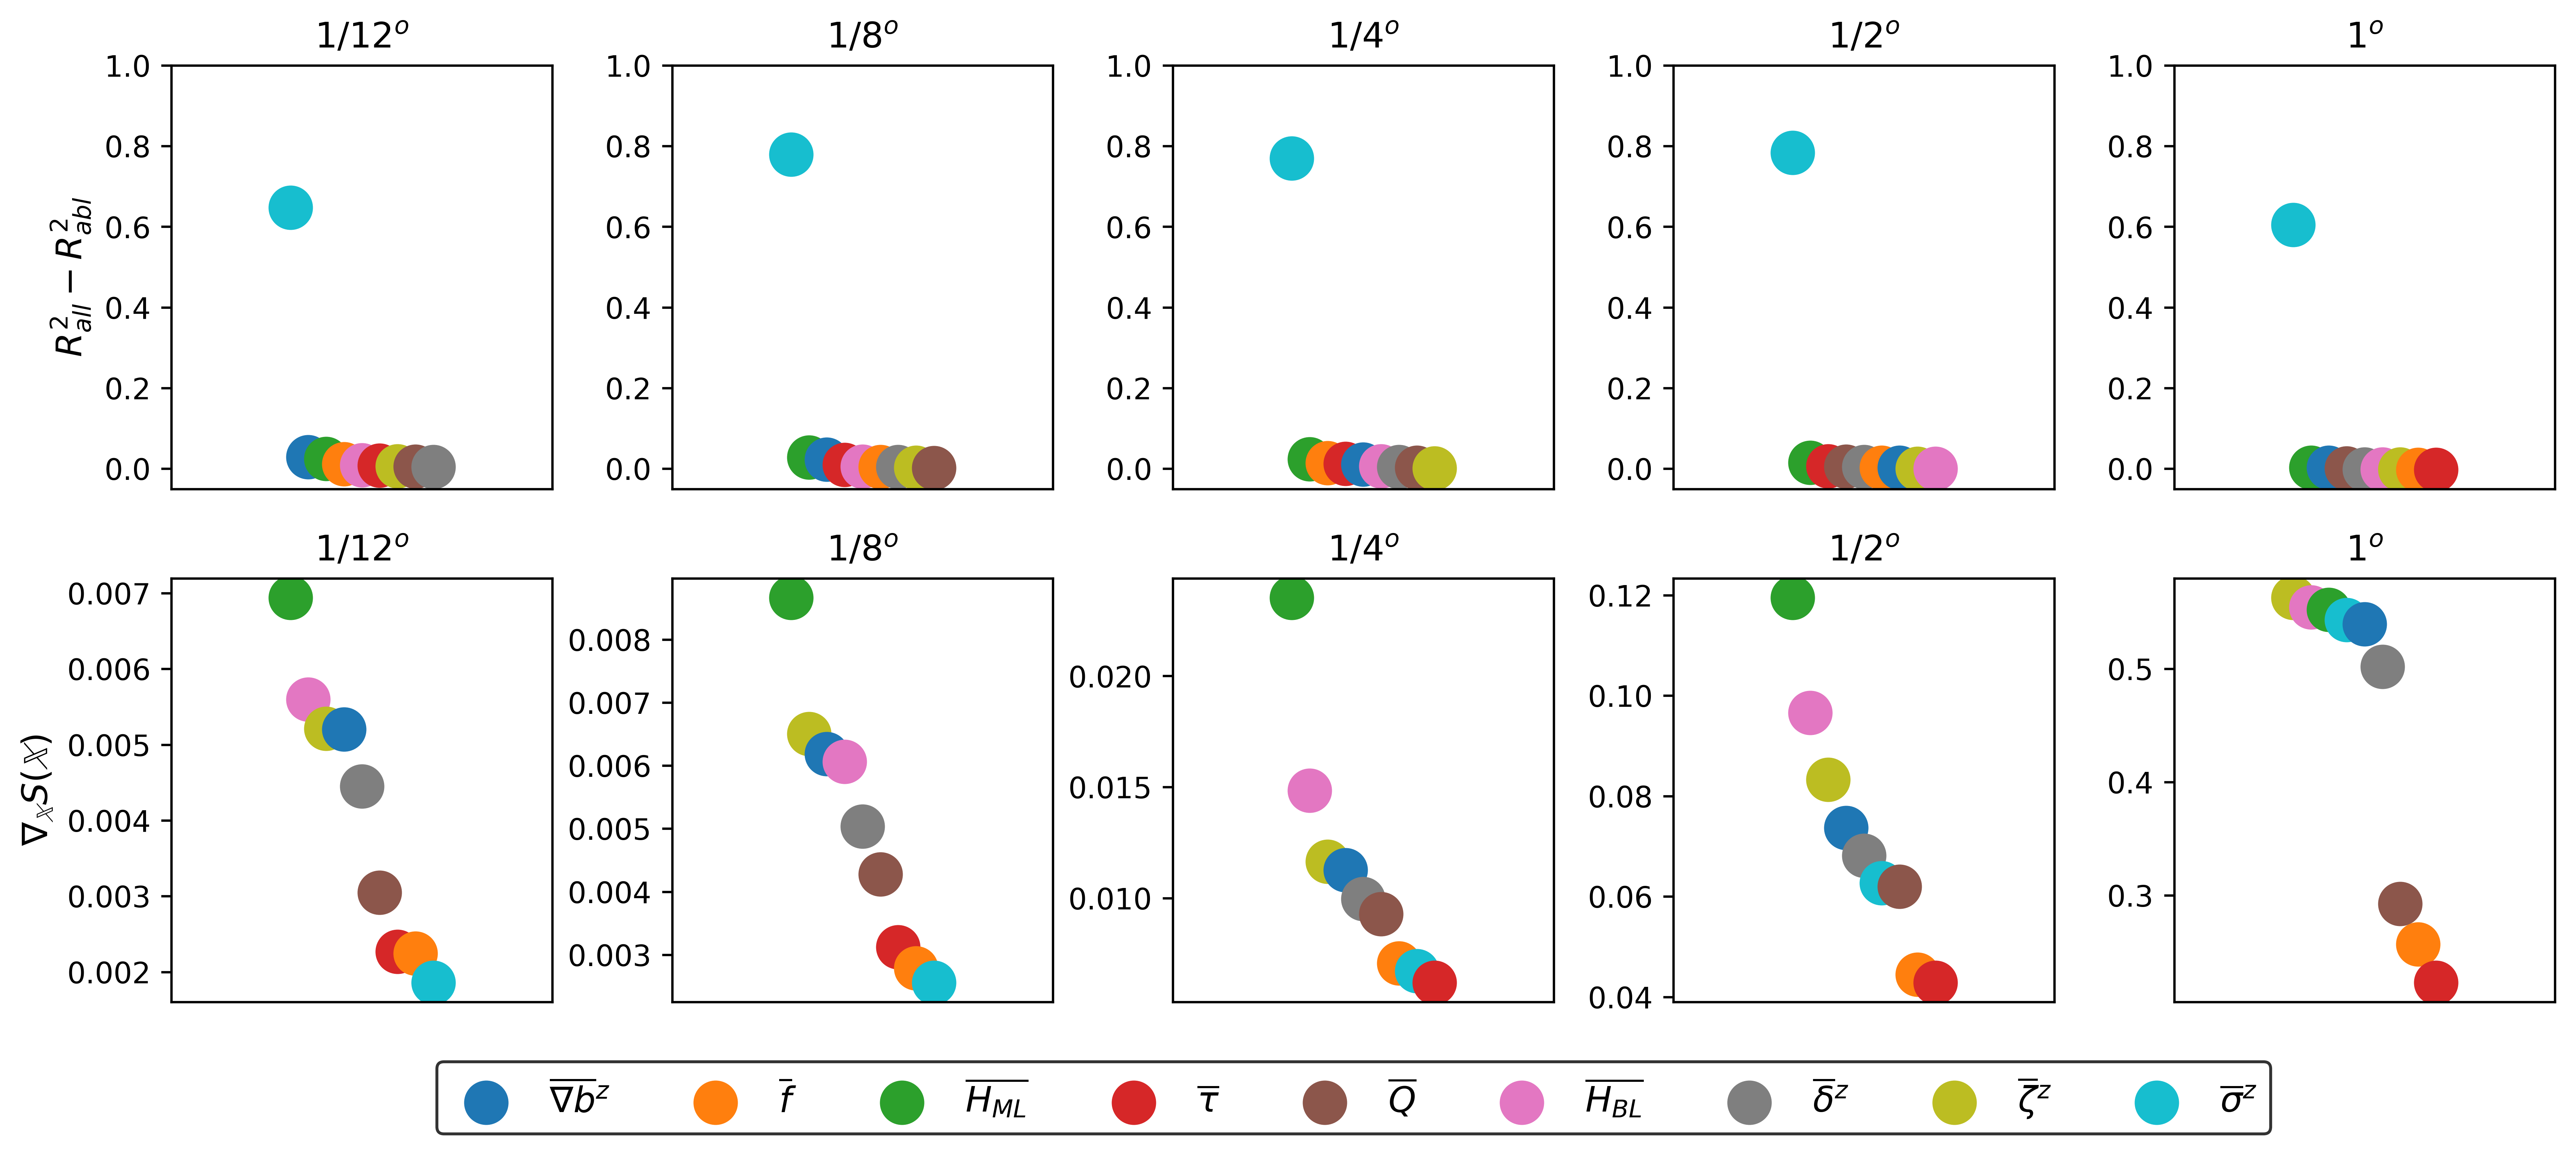

In [9]:
import matplotlib.cm as cm

fig, main_ax = plt.subplots(nrows=2, ncols=5,figsize=(12,5),dpi=600)
fig.tight_layout(pad=1)
#plt.rcParams['text.usetex'] = True

color = cm.tab10(np.linspace(0, 1, 9))    
for i_res in range(5):
    ax = plt.subplot(2,5,i_res+1)
    r2_res_argsort = np.argsort(r2_cnn[i_res]-r2_m_ftr[i_res,:])[::-1]
    #plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)
    for i_ftr, c_loc in zip(range(9),color[r2_res_argsort]):
        plt.scatter(np.linspace(-.3,.3,9)[i_ftr],r2_cnn[i_res]-r2_m_ftr[i_res,r2_res_argsort[i_ftr]],s=200,color=c_loc, label=input_features_for_plot[i_ftr])
        plt.title(res_for_plot[i_res],fontsize=12)
        plt.xticks([])
        if i_res==0:
            plt.ylabel('$R_{all}^2-R_{abl}^2$',fontsize=12)
        plt.ylim([-0.05,1])
        plt.xlim([-.8,.8])
    
    ax = plt.subplot(2,5,6+i_res)
    #plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)
    jacobian_ftr_res_argsort = np.argsort(jacobian_ftr_res[i_res,:])[::-1]
    for i_ftr, c_loc in zip(range(9),color[jacobian_ftr_res_argsort]):
        plt.scatter(np.linspace(-.3,.3,9)[i_ftr],jacobian_ftr_res[i_res,jacobian_ftr_res_argsort[i_ftr]],s=200,color=c_loc,label=input_features_for_plot[jacobian_ftr_res_argsort[i_ftr]])
        plt.title(res_for_plot[i_res])
        plt.xticks([])
        if i_res==0:
            plt.ylabel(r'$\nabla_{\mathbb{X}}S(\mathbb{X})$',fontsize=12)
        #plt.ylim([0,1])
        plt.xlim([-.8,.8])

# reordering the labels 
handles, labels = plt.gca().get_legend_handles_labels() 

# order
order = [4, 7, 2, 8, 6, 1, 5, 0, 3]

# pass handle & labels lists along with order as below 
plt.legend([handles[i] for i in order], [labels[i] for i in order],fontsize=12,bbox_to_anchor=(.3, -0.1),ncol=9).get_frame().set_edgecolor('k') 

#plt.legend(fontsize=12,bbox_to_anchor=(.3, -0.1),ncol=9).get_frame().set_edgecolor('k')

plt.savefig('./figures/feature_importance_r2_rel_jacobian',bbox_inches = 'tight')